In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow as tf
from tensorflow.keras import layers, models
import glob
import os
import pandas as pd
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

2025-06-18 14:05:24.049802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750255524.262333      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750255524.313714      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Path to dataset files: /kaggle/input/plantdisease


In [2]:
data_dir = '/kaggle/input/plantdisease/PlantVillage'

categories = os.listdir(data_dir)
print("Classes:", categories)

data_dir = '/kaggle/input/plantdisease/PlantVillage'  # adjust if needed

batch_size = 64
img_height = 150
img_width = 150
seed = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(categories)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Dense Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Classes: ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']
Found 20638 files belonging to 15 classes.
Using 16511 files for training.


I0000 00:00:1750255556.584411      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750255556.585161      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [3]:
data_dir = "/kaggle/input/plantdisease/PlantVillage"
img_size = 128

categories = os.listdir(data_dir)
print("Classes:", categories)

data = []
labels = []

for i, category in tqdm(enumerate(categories)):
    folder_path = os.path.join(data_dir, category)
    for img in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, img)
            img_arr = cv2.imread(img_path)
            img_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append(img_arr)
            labels.append(i)
        except Exception as e:
            pass  # Skip unreadable images

print("Total images:", len(data))

Classes: ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']


15it [02:51, 11.44s/it]

Total images: 20638


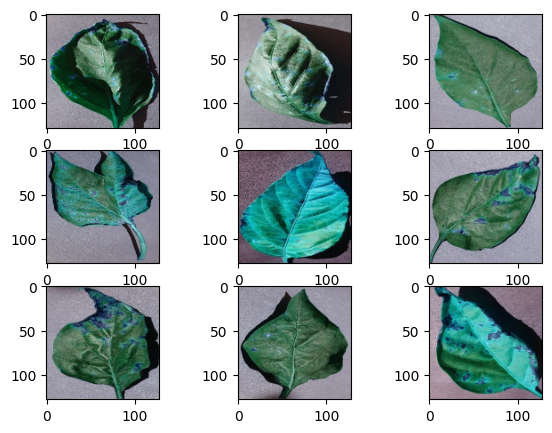

In [4]:
fig, axs = plt.subplots(3, 3, figsize = (7, 5))
cnt = 0
for i in range(3):
     for j in range(3):
         axs[i, j].imshow(data[cnt])
         cnt += 1

In [5]:
data = np.array(data) / 255.0 
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))

print(f"\nDataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Dataset shapes:
X_train: (16510, 128, 128, 3), y_train: (16510, 15)
X_test: (4128, 128, 128, 3), y_test: (4128, 15)


In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(15, activation= 'softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,699,919 (6.48 MB)

 Trainable params: 1,699,919 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy',  metrics=['accuracy'])

model.evaluate(X_test, y_test)

epochs = 50

history = model.fit(
    X_train, y_train,
    batch_size = 64,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test)
)

I0000 00:00:1750255743.725910      67 service.cc:148] XLA service 0x7f2a480033c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750255743.726768      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750255743.726798      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750255743.844823      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


 27/129 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0378 - loss: 2.7132

I0000 00:00:1750255745.504758      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0440 - loss: 2.7124
Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.3762 - loss: 1.9505 - val_accuracy: 0.7313 - val_loss: 0.7868
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7810 - loss: 0.6518 - val_accuracy: 0.7977 - val_loss: 0.5935
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8525 - loss: 0.4368 - val_accuracy: 0.8714 - val_loss: 0.3876
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9082 - loss: 0.2747 - val_accuracy: 0.8709 - val_loss: 0.3801
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9290 - loss: 0.2113 - val_accuracy: 0.8733 - val_loss: 0.3943
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9469 - loss: 0.1557 - val_accuracy: 0.8963 - val_loss: 0.3298
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9661 - loss: 0.1031 - val_accuracy: 0.9004 - val_loss: 0.3282
Epoch 8/50
258/258 ━━

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


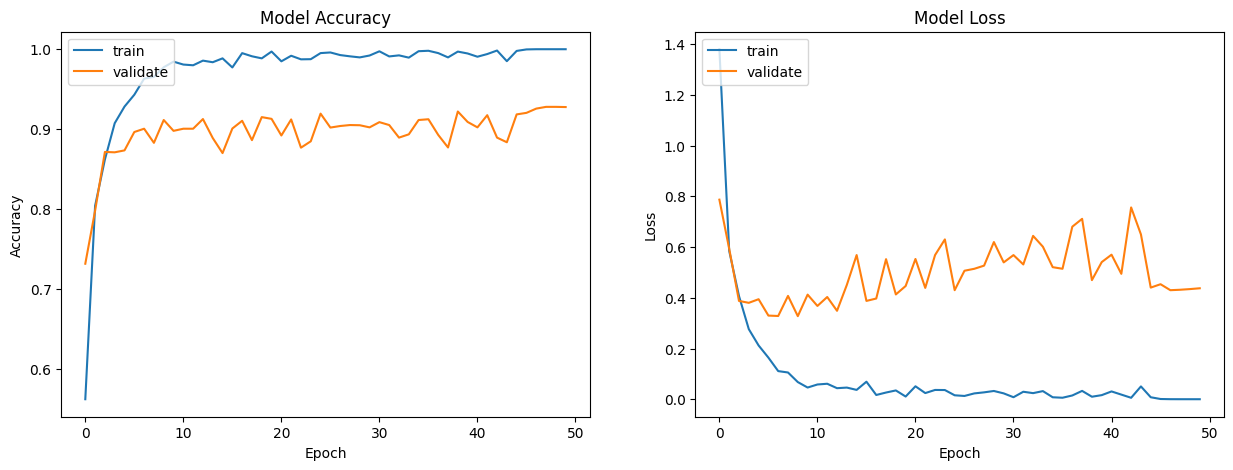


 Final Training Metrics:
• Training Accuracy: 100.00%
• Validation Accuracy: 92.76%
• Training Loss: 0.00%
• Validation Loss: 43.75%


In [8]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# # list all data in history
print(history.history.keys())

plotmodelhistory(history)

final_train_acc = history.history['accuracy'][-1] * 100
final_val_acc = history.history['val_accuracy'][-1] * 100
final_train_loss = history.history['loss'][-1] * 100
final_val_loss = history.history['val_loss'][-1] * 100

print("\n Final Training Metrics:")
print(f"• Training Accuracy: {final_train_acc:.2f}%")
print(f"• Validation Accuracy: {final_val_acc:.2f}%")
print(f"• Training Loss: {final_train_loss:.2f}%") 
print(f"• Validation Loss: {final_val_loss:.2f}%")

In [9]:
# Get predicted class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels (integers)
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted classes (0, 1, 2, ...)
y_true = np.argmax(y_test, axis=1)        # True classes (if y_test is one-hot encoded)

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


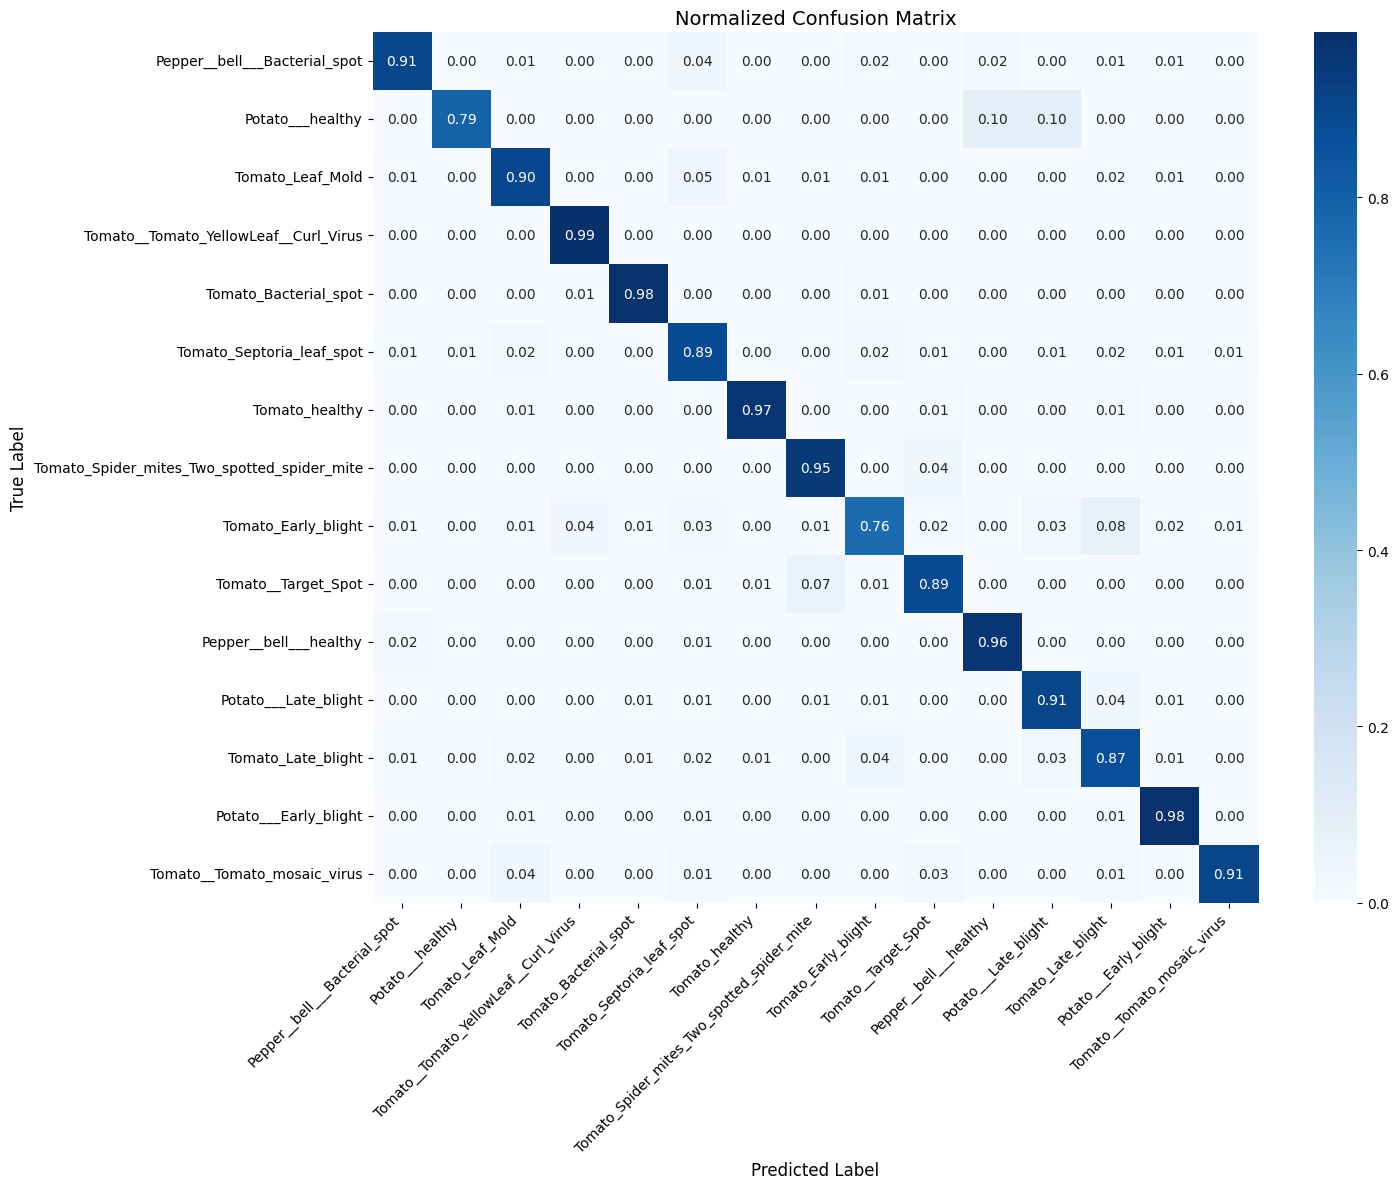

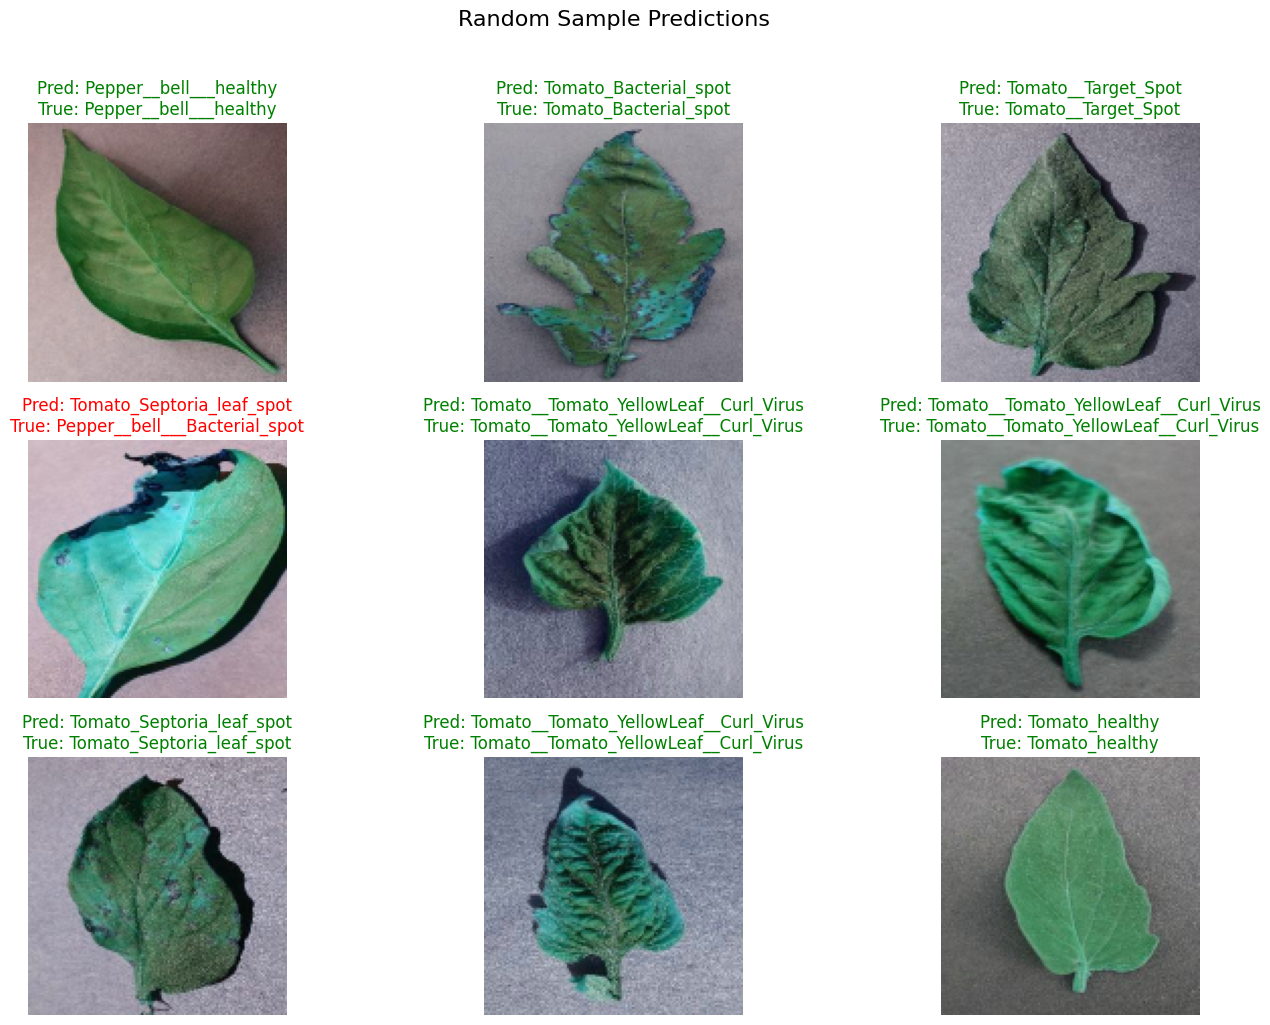

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random

# 1. First generate predictions if not already done
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 2. Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Improved confusion matrix visualization
plt.figure(figsize=(15,12))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=categories, 
            yticklabels=categories)
plt.title("Normalized Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Sample predictions visualization with error handling
plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    rand_idx = random.randint(0, len(X_test)-1)
    
    # Ensure the image is in correct format for display
    display_img = X_test[rand_idx]
    if display_img.max() <= 1.0:  # If normalized to [0,1]
        display_img = (display_img * 255).astype(np.uint8)
    
    plt.imshow(display_img)
    pred = categories[y_pred[rand_idx]]
    true = categories[y_true[rand_idx]]
    color = 'green' if pred == true else 'red'
    plt.title(f"Pred: {pred}\nTrue: {true}", color=color)
    plt.axis('off')
plt.suptitle("Random Sample Predictions", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()